In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import clean data

In [2]:
#Read data from file
filename = 'data_clean.csv'
df = pd.read_csv(filename)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15079 entries, 0 to 15078
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            15079 non-null  int64  
 1   room_type             15079 non-null  object 
 2   accommodates          15079 non-null  int64  
 3   bedrooms              15079 non-null  float64
 4   beds                  15079 non-null  float64
 5   host_response_rate    15079 non-null  int64  
 6   latitude              15079 non-null  float64
 7   longitude             15079 non-null  float64
 8   number_of_reviews     15079 non-null  int64  
 9   review_scores_rating  15079 non-null  float64
 10  bath_size             15079 non-null  float64
 11  bath_type             15079 non-null  object 
 12  price_log             15079 non-null  float64
dtypes: float64(7), int64(4), object(2)
memory usage: 1.5+ MB


# Model

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

In [5]:
x = pd.get_dummies(df).drop(columns=['price_log'])

y = df['price_log']

print('shape of x = ', x.shape)
print('shape of y = ' , y.shape)

shape of x =  (15079, 18)
shape of y =  (15079,)


In [6]:
x_train1, x_test, y_train1, y_test = train_test_split(x, y, test_size=0.1, random_state=123)
x_train, x_valid, y_train, y_valid = train_test_split(x_train1, y_train1, test_size=2/9, random_state=123)

print('training-set = {:.2f} %'.format(x_train.shape[0]/x.shape[0]))
print('validation-set = {:.2f} %'.format(x_valid.shape[0]/x.shape[0]))
print('test-set = {:.2f} %'.format(x_test.shape[0]/x.shape[0]))

training-set = 0.70 %
validation-set = 0.20 %
test-set = 0.10 %


In [7]:
#sc = StandardScaler()

### Model 1 : Linear regression

In [8]:
reg = LinearRegression()
reg.fit(x_train, y_train)
reg_pred = reg.predict(x_valid)
print('R squeard = {:.2f}'.format(reg.score(x_valid, y_valid)))

R squeard = 0.22


In [9]:
# RMSE = sqr(MSE)
reg_rmse = mean_squared_error(y_valid, reg_pred, squared=False)
print('RMSE = {:.2f}'.format(reg_rmse))

RMSE = 0.62


In [10]:
# try cross validation

kf = KFold(n_splits=5, shuffle=True, random_state = 123)
cv_reg = cross_validate(reg, x_train1, y_train1, cv = kf, scoring = ['r2','neg_root_mean_squared_error'])


print(cv_reg['test_r2'])
print('Avearge of R2 = {:.2f}'.format(cv_reg['test_r2'].mean()))

print('============================================================')

rmse_regcv = cv_reg['test_neg_root_mean_squared_error']*-1
print(rmse_regcv)
print('Avearge of RMSE = {:.2f} '.format(rmse_regcv.mean()))


[0.21787885 0.2533226  0.25170751 0.24905463 0.24253654]
Avearge of R2 = 0.24
[0.62337365 0.60745681 0.60743619 0.60402772 0.61721605]
Avearge of RMSE = 0.61 


### Model 2 : Ridge regression

In [11]:
# default
ridge = Ridge()
ridge.fit(x_train, y_train) 
ridge_pred = ridge.predict(x_valid)
print('R squeard = {:.2f}'.format(ridge.score(x_valid, y_valid)))

# RMSE = sqr(MSE)
ridge_rmse = mean_squared_error(y_valid, ridge_pred, squared=False)
print('RMSE = {:.2f}'.format(ridge_rmse))

R squeard = 0.22
RMSE = 0.62


In [12]:
# try cross validation

kf = KFold(n_splits=5, shuffle=True, random_state = 123)
cv_ridge = cross_validate(ridge, x_train1, y_train1, cv = kf, scoring = ['r2','neg_root_mean_squared_error'])


print(cv_ridge['test_r2'])
print('Avearge of R2 = {:.2f}'.format(cv_ridge['test_r2'].mean()))

print('============================================================')

rmse_ridcv = cv_ridge['test_neg_root_mean_squared_error']*-1
print(rmse_ridcv)
print('Avearge of RMSE = {:.2f} '.format(rmse_ridcv.mean()))


[0.21774997 0.25357465 0.25180278 0.24891933 0.24242426]
Avearge of R2 = 0.24
[0.623425   0.60735427 0.60739752 0.60408213 0.6172618 ]
Avearge of RMSE = 0.61 


#### tune alpha

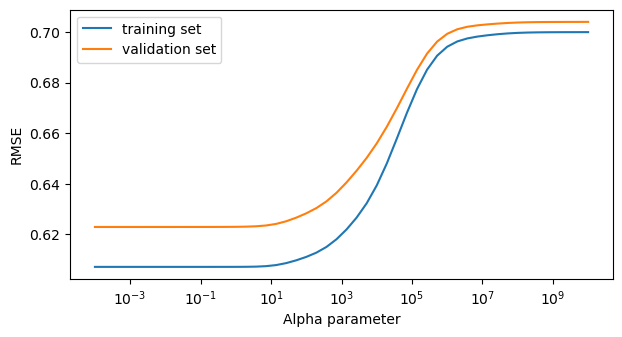

In [13]:
rmse_train = list()
rmse_val = list()
ridge_alpha = [10**x for x in np.linspace(-4,10)]

for a in ridge_alpha :
    model = Ridge(alpha = a)
    model.fit(x_train, y_train)
    pred_train = model.predict(x_train)
    pred_val = model.predict(x_valid)
    train = mean_squared_error(y_train, pred_train, squared=False)
    val = mean_squared_error(y_valid, pred_val, squared=False)
    rmse_train.append(train)
    rmse_val.append(val)
    
plt.figure(figsize=(7,3.5))
plt.plot(ridge_alpha, rmse_train, label = 'training set')
plt.plot(ridge_alpha, rmse_val, label = 'validation set')
plt.xscale('log')
plt.xlabel('Alpha parameter')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [14]:
ridge_alpha = [10**x for x in np.linspace(-4,2)]
ridge_param = { 'alpha' : ridge_alpha}

ridge_kf = KFold(n_splits = 5, shuffle=True, random_state = 123)
ridge_grid = GridSearchCV(ridge, ridge_param, cv = ridge_kf, scoring = 'neg_root_mean_squared_error')
tune_ridge = ridge_grid.fit(x_train,y_train)

print('Best parameter :', tune_ridge.best_params_)
print('Best RMSE = {:.2f}'.format( tune_ridge.best_score_ * -1 ))

Best parameter : {'alpha': 0.35564803062231287}
Best RMSE = 0.61


### Model 3 : Lasso regression

In [15]:
# default
lasso = Lasso()
lasso.fit(x_train, y_train) 
lasso_pred = lasso.predict(x_valid)
print('R squeard = {:.2f}'.format(lasso.score(x_valid, y_valid)))

# RMSE = sqr(MSE)
lasso_rmse = mean_squared_error(y_valid, lasso_pred, squared=False)
print('RMSE = {:.2f}'.format(lasso_rmse))

R squeard = 0.01
RMSE = 0.70


In [16]:
# try cross validation

kf = KFold(n_splits=5, shuffle=True, random_state = 123)
cv_lasso = cross_validate(lasso, x_train1, y_train1, cv = kf, scoring = ['r2','neg_root_mean_squared_error'])


print(cv_lasso['test_r2'])
print('Avearge of R2 = {:.2f}'.format(cv_lasso['test_r2'].mean()))

print('============================================================')

rmse_lascv = cv_lasso['test_neg_root_mean_squared_error']*-1
print(rmse_lascv)
print('Avearge of RMSE = {:.2f} '.format(rmse_lascv.mean()))

[0.0079597  0.00636643 0.00770253 0.00770339 0.00489224]
Avearge of R2 = 0.01
[0.70206299 0.70074826 0.69949709 0.69434203 0.70744295]
Avearge of RMSE = 0.70 


#### tune alpha

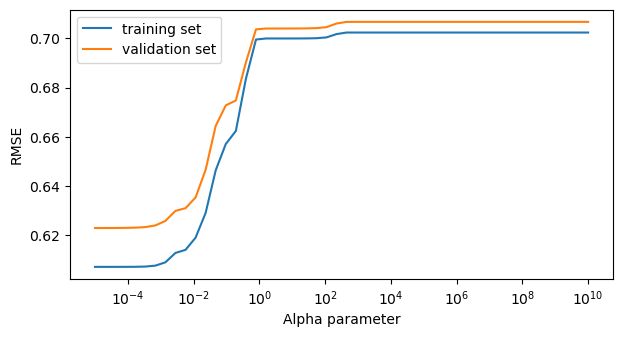

In [17]:
rmse_train = list()
rmse_val = list()
lasso_alpha = [10**x for x in np.linspace(-5,10)]

for a in lasso_alpha :
    model = Lasso(alpha = a)
    model.fit(x_train, y_train)
    pred_train = model.predict(x_train)
    pred_val = model.predict(x_valid)
    train = mean_squared_error(y_train, pred_train, squared=False)
    val = mean_squared_error(y_valid, pred_val, squared=False)
    rmse_train.append(train)
    rmse_val.append(val)

plt.figure(figsize=(7,3.5))
plt.plot(lasso_alpha, rmse_train, label = 'training set')
plt.plot(lasso_alpha, rmse_val, label = 'validation set')
plt.xscale('log')
plt.xlabel('Alpha parameter')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [18]:
lasso_alpha = [10**x for x in np.linspace(-4,0)]
lasso_param = { 'alpha' : lasso_alpha}

lasso_kf = KFold(n_splits = 5, shuffle=True, random_state = 123)
lasso_grid = GridSearchCV(lasso, lasso_param, cv = lasso_kf, scoring = 'neg_root_mean_squared_error')
tune_lasso = lasso_grid.fit(x_train,y_train)

print('Best parameter :', tune_lasso.best_params_)
print('Best RMSE = {:.2f}'.format( tune_lasso.best_score_ * -1 ))

Best parameter : {'alpha': 0.0001}
Best RMSE = 0.61


### Model 4 : KNN

In [19]:
# default
knn = KNeighborsRegressor()
knn.fit(x_train,y_train)
knn_pred = knn.predict(x_valid)

# RMSE = sqr(MSE)
knn_rmse = mean_squared_error(y_valid, knn_pred, squared=False)
print('RMSE = {:.2f}'.format(knn_rmse))

RMSE = 0.72


In [20]:
# try cross validation

kf = KFold(n_splits=5, shuffle=True, random_state = 123)
cv_knn = cross_validate(knn, x_train1, y_train1, cv = kf, scoring = ['neg_root_mean_squared_error'])

print('============================================================')

rmse_knncv = cv_knn['test_neg_root_mean_squared_error']*-1
print(rmse_knncv)
print('Avearge of RMSE = {:.2f} '.format(rmse_knncv.mean()))

[0.72036792 0.70802402 0.71695369 0.71281421 0.73047719]
Avearge of RMSE = 0.72 


#### tune KNN paremeters

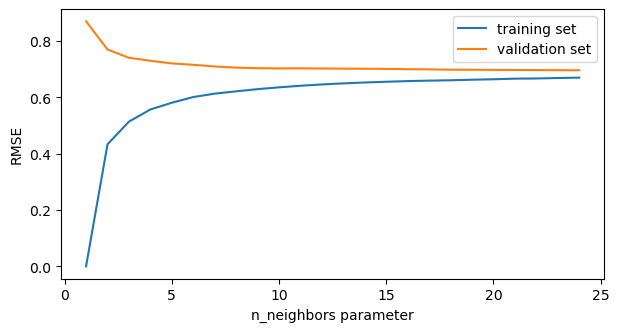

In [21]:
rmse_train = list()
rmse_val = list()
n_neighbors = [x for x in np.arange(1,25,1)]

for n in n_neighbors :
    model = KNeighborsRegressor(n_neighbors = n)
    model.fit(x_train, y_train)
    pred_train = model.predict(x_train)
    pred_val = model.predict(x_valid)
    train = mean_squared_error(y_train, pred_train, squared=False)
    val = mean_squared_error(y_valid, pred_val, squared=False)
    rmse_train.append(train)
    rmse_val.append(val)

plt.figure(figsize=(7,3.5))
plt.plot(n_neighbors, rmse_train, label = 'training set')
plt.plot(n_neighbors, rmse_val, label = 'validation set')
plt.xlabel('n_neighbors parameter')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [22]:
knn_param = {'n_neighbors' : [x for x in np.arange(5,25,1)],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

knn_kf = KFold(n_splits = 5, shuffle=True, random_state = 123)
knn_grid = GridSearchCV(knn, knn_param, cv = knn_kf, scoring = 'neg_root_mean_squared_error')
tune_knn = knn_grid.fit(x_train,y_train)

print('Best parameter :', tune_knn.best_params_)
print('Best RMSE = {:.2f}'.format( tune_knn.best_score_ * -1 ))

Best parameter : {'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}
Best RMSE = 0.67


### Model 5 : RandomForest

In [23]:
#defalut
rf = RandomForestRegressor()
rf.fit(x_train,y_train)
rf_pred = rf.predict(x_valid)

rf_rmse = mean_squared_error(y_valid, rf_pred, squared=False)
print('RMSE = {:.2f}'.format(rf_rmse))

RMSE = 0.49


In [24]:
# try cross validation

kf = KFold(n_splits=5, shuffle=True, random_state = 123)
cv_rf = cross_validate(rf, x_train1, y_train1, cv = kf, scoring = ['neg_root_mean_squared_error'])

print('============================================================')

rmse_rfcv = cv_rf['test_neg_root_mean_squared_error']*-1
print(rmse_rfcv)
print('Avearge of RMSE = {:.2f} '.format(rmse_rfcv.mean()))

[0.48010007 0.46493296 0.46958081 0.47362764 0.48424175]
Avearge of RMSE = 0.47 


#### tune RandomForest paremeters

### Model 6 : XGboost

In [25]:
!pip install xgboost

In [26]:
from xgboost import XGBRegressor

In [27]:
#defalut
xgb = XGBRegressor()
xgb.fit(x_train,y_train)
xgb_pred = xgb.predict(x_valid)

xgb_rmse = mean_squared_error(y_valid, xgb_pred, squared=False)
print('RMSE = {:.2f}'.format(xgb_rmse))

RMSE = 0.49


In [28]:
# try cross validation

kf = KFold(n_splits=5, shuffle=True, random_state = 123)
cv_xgb = cross_validate(xgb, x_train1, y_train1, cv = kf, scoring = ['neg_root_mean_squared_error'])

print('============================================================')

rmse_xgbcv = cv_xgb['test_neg_root_mean_squared_error']*-1
print(rmse_xgbcv)
print('Avearge of RMSE = {:.2f} '.format(rmse_xgbcv.mean()))

[0.49288995 0.48680131 0.49999469 0.48796404 0.50264082]
Avearge of RMSE = 0.49 


#### tune XGB paremeters

- max_dept

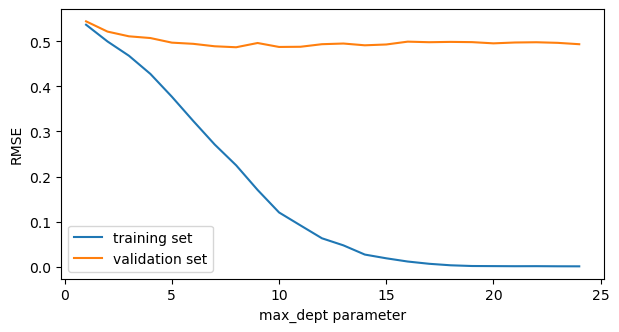

In [29]:
depth = np.arange(1,25,1)

rmse_train = list()
rmse_val = list()

for d in depth :
    model = XGBRegressor(max_depth = d)
    model.fit(x_train, y_train)
    pred_train = model.predict(x_train)
    pred_val = model.predict(x_valid)
    train = mean_squared_error(y_train, pred_train, squared=False)
    val = mean_squared_error(y_valid, pred_val, squared=False)
    rmse_train.append(train)
    rmse_val.append(val)

plt.figure(figsize=(7,3.5))
plt.plot(depth, rmse_train, label = 'training set')
plt.plot(depth, rmse_val, label = 'validation set')
plt.xlabel('max_dept parameter')
plt.ylabel('RMSE')
plt.legend()
plt.show()

- n_estimator

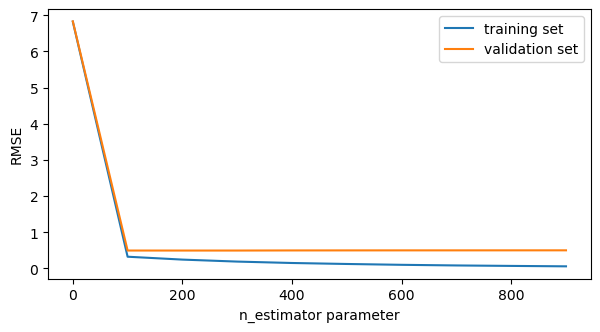

In [30]:
n_estimator = np.arange(0,1000,100)

rmse_train = list()
rmse_val = list()

for n in n_estimator :
    model = XGBRegressor(n_estimators = n)
    model.fit(x_train, y_train)
    pred_train = model.predict(x_train)
    pred_val = model.predict(x_valid)
    train = mean_squared_error(y_train, pred_train, squared=False)
    val = mean_squared_error(y_valid, pred_val, squared=False)
    rmse_train.append(train)
    rmse_val.append(val)

plt.figure(figsize=(7,3.5))
plt.plot(n_estimator, rmse_train, label = 'training set')
plt.plot(n_estimator, rmse_val, label = 'validation set')
plt.xlabel('n_estimator parameter')
plt.ylabel('RMSE')
plt.legend()
plt.show()

- learning rate

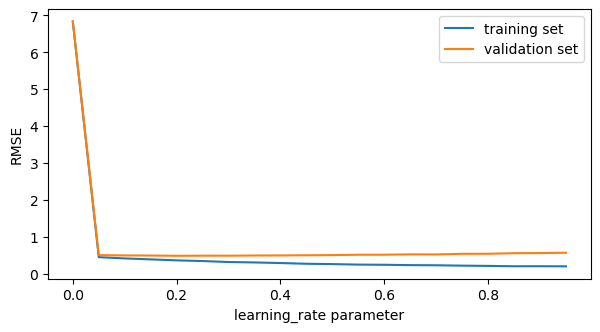

In [31]:
lr = np.arange(0,1,0.05)

rmse_train = list()
rmse_val = list()

for r in lr :
    model = XGBRegressor(learning_rate = r)
    model.fit(x_train, y_train)
    pred_train = model.predict(x_train)
    pred_val = model.predict(x_valid)
    train = mean_squared_error(y_train, pred_train, squared=False)
    val = mean_squared_error(y_valid, pred_val, squared=False)
    rmse_train.append(train)
    rmse_val.append(val)

plt.figure(figsize=(7,3.5))
plt.plot(lr, rmse_train, label = 'training set')
plt.plot(lr, rmse_val, label = 'validation set')
plt.xlabel('learning_rate parameter')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [36]:
xgb_param = {"max_depth": [7,8,9],
              "n_estimators": [200],
              "learning_rate": np.arange(0.1,0.2,0.01) }

xgb_kf = KFold(n_splits = 5, shuffle=True, random_state = 123)
xgb_grid = GridSearchCV(xgb, xgb_param, cv = xgb_kf, scoring = 'neg_root_mean_squared_error')
tune_xgb = xgb_grid.fit(x_train,y_train)

print('Best parameter :', tune_xgb.best_params_)
print('Best RMSE = {:.2f}'.format( tune_xgb.best_score_ * -1 ))

Best parameter : {'learning_rate': 0.15999999999999998, 'max_depth': 9, 'n_estimators': 200}
Best RMSE = 0.48


# Compare model

In [37]:
# model = {}

# for model, params in model.items() :
#     print('===')